
In this notebook, You will do amazon review classification with BERT.[Download data from [this](https://www.kaggle.com/snap/amazon-fine-food-reviews/data) link]
<pre> 
It contains 5 parts as below.  Detailed instrctions are given in the each cell. please read every comment we have written. 
    1. Preprocessing 
    2. Creating a BERT model from the Tensorflow HUB.
    3. Tokenization
    4. getting the pretrained embedding Vector for a given review from the BERT.
    5. Using the embedding data apply NN and classify the reviews.
    6. Creating a Data pipeline for BERT Model. 

<font size=5>instructions:</font>

    1. Don't change any Grader Functions. Don't manipulate any Grader functions. 
    If you manipulate any, it will be considered as plagiarised. 
    
    2. Please read the instructions on the code cells and markdown cells. We will explain what to write. 
    
    3. please return outputs in the same format what we asked. Eg. Don't return List if we are asking for a numpy array.
    
    4. Please read the external links that we are given so that you will learn the concept behind the code that you are writing.
    
    5. We are giving instructions at each section if necessary, please follow them. 

<font size=5>Every Grader function has to return True. </font>
</pre>

In [1]:
#all imports
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import pickle
from tensorflow.keras.models import Model

In [2]:
import warnings
warnings.filterwarnings("ignore") 

In [3]:
#pip install tensorflow_hub

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

<font size=4>Grader function 1 </font>

In [5]:
def grader_tf_version():
    assert((tf.__version__)>'2')
    return True
grader_tf_version()

True

<pre><font size=6>Part-1: Preprocessing</font></pre>

In [6]:
#Read the dataset - Amazon fine food reviews
reviews = pd.read_csv(r"Reviews.csv")
#check the info of the dataset
reviews.info()

FileNotFoundError: [Errno 2] No such file or directory: 'Reviews.csv'

In [7]:
#get only 2 columns - Text, Score

reviews = reviews.drop(["Id","ProductId","UserId","ProfileName","HelpfulnessNumerator","HelpfulnessDenominator","Time","Summary"],axis = 1)
reviews = reviews.dropna()
#drop the NAN values

In [8]:
#if score> 3, set score = 1
#if score<=2, set score = 0
#if score == 3, remove the rows. 

reviews.drop(reviews.loc[reviews['Score']==3].index, inplace=True)
reviews.loc[reviews['Score'] <3 ,'Score'] = 0
reviews.loc[reviews['Score'] >3 ,'Score'] = 1




In [9]:
reviews.head()

,Score,Text
0,1,I have bought several of the Vitality canned d...
1,0,Product arrived labeled as Jumbo Salted Peanut...
2,1,This is a confection that has been around a fe...
3,0,If you are looking for the secret ingredient i...
4,1,Great taffy at a great price. There was a wid...


<font size=4>Grader function 2 </font>

In [10]:
def grader_reviews():
    temp_shape = (reviews.shape == (525814, 2)) and (reviews.Score.value_counts()[1]==443777)
    assert(temp_shape == True)
    return True
grader_reviews()

True

In [11]:
def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews = reviews.sample(n=100000, random_state=30)

In [12]:
reviews.head()

,Score,Text,len
64117,1,The tea was of great quality and it tasted lik...,30
418112,1,My cat loves this. The pellets are nice and s...,31
357829,1,Great product. Does not completely get rid of ...,41
175872,1,This gum is my favorite! I would advise every...,27
178716,1,I also found out about this product because of...,22


In [79]:
import re                #------#https://stackoverflow.com/questions/41569357/how-to-strip-all-tags-except-br-in-re-compile-python

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

In [13]:
#remove HTML from the Text column and save in the Text column only
reviews["Text"].apply(cleanhtml)


64117     The tea was of great quality and it tasted lik...
418112    My cat loves this.  The pellets are nice and s...
357829    Great product. Does not completely get rid of ...
175872    This gum is my favorite!  I would advise every...
178716    I also found out about this product because of...
                                ...                        
336657    Using this coffee and a stove top espresso mak...
498034    THE TASTE OF THIS M&M IS THE BEST. I USED IT I...
357766    Excellent Tea. I enjoy a cup every now and the...
326811    These oatmeal cookies have a great spice taste...
19261     This is the best coffee ever! I will never dri...
Name: Text, Length: 100000, dtype: object

In [14]:
#print head 5

In [15]:
reviews = reviews[['Text','len','Score']]
reviews.reset_index(drop=True).head()

,Text,len,Score
0,The tea was of great quality and it tasted lik...,30,1
1,My cat loves this. The pellets are nice and s...,31,1
2,Great product. Does not completely get rid of ...,41,1
3,This gum is my favorite! I would advise every...,27,1
4,I also found out about this product because of...,22,1


In [16]:
X = reviews['Text'].values
y = reviews['Score'].values

In [17]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [18]:
#split the data into train and test data(20%) with Stratify sampling, random state 33, 

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=33)

In [19]:
#plot bar graphs of y_train and y_test

In [20]:
#saving to disk. if we need, we can load preprocessed data directly. 
reviews.to_csv('preprocessed.csv', index=False)

<pre><font size=6>Part-2: Creating BERT Model</font> 

If you want to know more about BERT, You can watch live sessions on Transformers and BERt. 
we will strongly recommend you to read <a href="https://jalammar.github.io/illustrated-transformer/">Transformers</a>, <a href="https://arxiv.org/abs/1810.04805">BERT Paper</a> and, <a href="https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">This blog</a>.


For this assignment, we are using <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1">BERT uncased Base model</a>. 
It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. </pre>

In [82]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. You can change this
max_seq_length = 55

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


In [83]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 55)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 55)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [84]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

<pre><font size=6>Part-3: Tokenization</font></pre>

In [85]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [38]:
#pip install sentencepiece

Note: you may need to restart the kernel to use updated packages.


In [86]:
#import tokenization - We have given tokenization.py file
import tokenization

In [26]:
# Create tokenizer " Instantiate FullTokenizer" 
# name must be "tokenizer"
# the FullTokenizer takes two parameters 1. vocab_file and 2. do_lower_case 
# we have created these in the above cell ex: FullTokenizer(vocab_file, do_lower_case )
# please check the "tokenization.py" file the complete implementation

In [87]:
tokenizer = tokenization.FullTokenizer(vocab_file,do_lower_case)

<font size=4>Grader function 3 </font>

In [28]:
#it has to give no error 
def grader_tokenize(tokenizer):
    out = False
    try:
        out=('[CLS]' in tokenizer.vocab) and ('[SEP]' in tokenizer.vocab)
    except:
        out = False
    assert(out==True)
    return out
grader_tokenize(tokenizer)

True

In [29]:
# Create train and test tokens (X_train_tokens, X_test_tokens) from (X_train, X_test) using Tokenizer and 

# add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 

# maximum number of tokens is 55(We already given this to BERT layer above) so shape is (None, 55)

# if it is less than 55, add '[PAD]' token else truncate the tokens length.(similar to padding)

# Based on padding, create the mask for Train and Test ( 1 for real token, 0 for '[PAD]'), 
# it will also same shape as input tokens (None, 55) save those in X_train_mask, X_test_mask

# Create a segment input for train and test. We are using only one sentence so all zeros. This shape will also (None, 55)

# type of all the above arrays should be numpy arrays

# after execution of this cell, you have to get 
# X_train_tokens, X_train_mask, X_train_segment
# X_test_tokens, X_test_mask, X_test_segment

#### Example
<img src='https://i.imgur.com/5AhhmgU.png'>

In [30]:
from itertools import repeat

In [31]:
max_seq_length = 55

In [32]:
tokens_train_X = [tokenizer.tokenize(val) for val in X_train]
tokens_train = [sent[0:max_seq_length-2] for sent in tokens_train_X]

In [33]:
Xt_tokens =[]; Xt_mask = [];Xt_seg = []
for token in tokens_train:
    tokens = ['[CLS]',*token,'[SEP]']
    mask_arr = np.array([1]*len(tokens)+[0]*(max_seq_length-len(tokens)))
    tokens.extend(repeat('[PAD]',max_seq_length-len(tokens)))
    seg_arr = np.array([0]*max_seq_length)
    Xt_tokens.append(tokenizer.convert_tokens_to_ids(tokens))
    Xt_mask.append(mask_arr)
    Xt_seg.append(seg_arr)
    

In [34]:
X_train_tokens = np.array(Xt_tokens)
X_train_mask = np.array(Xt_mask)
X_train_segment = np.array(Xt_seg)

In [35]:
##  X_test

In [36]:
tokens_test_X = [tokenizer.tokenize(val) for val in X_test]
tokens_test = [sent[0:max_seq_length-2] for sent in tokens_test_X]

In [37]:
Xte_tokens =[]; Xte_mask = [];Xte_seg = []
for token in tokens_test:
    tokens = ['[CLS]',*token,'[SEP]']
    mask_arr = np.array([1]*len(tokens)+[0]*(max_seq_length-len(tokens)))
    tokens.extend(repeat('[PAD]',max_seq_length-len(tokens)))
    seg_arr = np.array([0]*max_seq_length)
    Xte_tokens.append(tokenizer.convert_tokens_to_ids(tokens))
    Xte_mask.append(mask_arr)
    Xte_seg.append(seg_arr)
    

In [38]:
X_test_tokens = np.array(Xte_tokens)
X_test_mask = np.array(Xte_mask)
X_test_segment = np.array(Xte_seg)

In [39]:
import pickle

In [41]:
##save all your results to disk so that, no need to run all again. 
# pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, y_train),open('train_data.pkl','wb'))
# pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, y_test),open('test_data.pkl','wb'))

In [42]:
#you can load from disk
#X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = pickle.load(open("train_data.pkl", 'rb')) 
#X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = pickle.load(open("test_data.pkl", 'rb')) 

<font size=4>Grader function 4 </font>

In [43]:
def grader_alltokens_train():
    out = False
    
    if type(X_train_tokens) == np.ndarray:
        
        temp_shapes = (X_train_tokens.shape[1]==max_seq_length) and (X_train_mask.shape[1]==max_seq_length) and \
        (X_train_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_train_segment)
        
        mask_temp = np.sum(X_train_mask==0) == np.sum(X_train_tokens==0)
        
        no_cls = np.sum(X_train_tokens==tokenizer.vocab['[CLS]'])==X_train_tokens.shape[0]
        
        no_sep = np.sum(X_train_tokens==tokenizer.vocab['[SEP]'])==X_train_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out

grader_alltokens_train()

True

<font size=4>Grader function 5 </font>

In [44]:
def grader_alltokens_test():
    out = False
    if type(X_test_tokens) == np.ndarray:
        
        temp_shapes = (X_test_tokens.shape[1]==max_seq_length) and (X_test_mask.shape[1]==max_seq_length) and \
        (X_test_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_test_segment)
        
        mask_temp = np.sum(X_test_mask==0) == np.sum(X_test_tokens==0)
        
        no_cls = np.sum(X_test_tokens==tokenizer.vocab['[CLS]'])==X_test_tokens.shape[0]
        
        no_sep = np.sum(X_test_tokens==tokenizer.vocab['[SEP]'])==X_test_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out
grader_alltokens_test()

True

<pre><font size=6>Part-4: Getting Embeddings from BERT Model</font>
We already created the BERT model in the part-2 and input data in the part-3. 
We will utlize those two and will get the embeddings for each sentence in the 
Train and test data.</pre>

In [45]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'segment_ids')>]

In [46]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [48]:
# get the train output, BERT model will give one output so save in
# X_train_pooled_output
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

In [49]:
# get the test output, BERT model will give one output so save in
# X_test_pooled_output
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

In [50]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train_pooled_output, X_test_pooled_output,y_train,y_test),open('final_output.pkl','wb'))

________________________

In [98]:
X_train_pooled_output,X_test_pooled_output,y_train,y_test= pickle.load(open('final_output.pkl', 'rb'))

<font size=4>Grader function 6 </font>

In [99]:
#now we have X_train_pooled_output, y_train
#X_test_pooled_ouput, y_test

#please use this grader to evaluate
def greader_output():
    assert(X_train_pooled_output.shape[1]==768)
    assert(len(y_train)==len(X_train_pooled_output))
    assert(X_test_pooled_output.shape[1]==768)
    assert(len(y_test)==len(X_test_pooled_output))
    assert(len(y_train.shape)==1)
    assert(len(X_train_pooled_output.shape)==2)
    assert(len(y_test.shape)==1)
    assert(len(X_test_pooled_output.shape)==2)
    return True
greader_output()

True

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

<pre><font size=6>Part-5: Training a NN with 768 features</font>

Create a NN and train the NN. 
1.<b> You have to use AUC as metric.</b> 
2. You can use any architecture you want. 
3. You have to use tensorboard to log all your metrics and Losses. You have to send those logs. 
4. Print the loss and metric at every epoch. 
5. You have to submit without overfitting and underfitting. 
</pre>

In [116]:
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras import regularizers
from keras.regularizers import l2
from keras.layers import Flatten
from keras.layers import Dense, Input , Dropout
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization

In [117]:
tf.keras.backend.clear_session()

In [118]:
input_layer = Input(shape=(768,), name='input')
flatten_1 = Flatten()(input_layer)
L = Dense(1024,activation = 'relu', kernel_initializer = 'glorot_normal', kernel_regularizer=regularizers.l2(0.001))(flatten_1)
L = Dense(512, activation = 'relu', kernel_initializer = 'glorot_normal', kernel_regularizer=regularizers.l2(0.001))(L)
L = Dense(128, activation = 'relu', kernel_initializer = 'glorot_normal', kernel_regularizer=regularizers.l2(0.001))(L)
L = Dense(64,  activation = 'relu', kernel_initializer = 'glorot_normal', kernel_regularizer=regularizers.l2(0.001))(L)
L = Dense(32,  activation = 'relu', kernel_initializer = 'glorot_normal', kernel_regularizer=regularizers.l2(0.001))(L)
L = Dense(8,   activation = 'relu', kernel_initializer = 'glorot_normal', kernel_regularizer=regularizers.l2(0.001))(L)
L = Dense(2,   activation = 'relu', kernel_initializer = 'glorot_normal', kernel_regularizer=regularizers.l2(0.001))(L)

output = Dense(1, activation='sigmoid', name='output')(L)
          

Model = Model(inputs =input_layer,outputs = output)
Model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 768)]             0         
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              787456    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080  

In [120]:
# from sklearn.preprocessing import LabelEncoder

# # creating instance of labelencoder
# labelencoder = LabelEncoder()

# y_train = labelencoder.fit_transform(y_train)
# y_test = labelencoder.fit_transform(y_test)

In [121]:
# # Our vectorized labels
# y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
# y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [72]:
# #creating categorical labels for our y data
# y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)     
# y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [122]:
# using label encoder to provide the binary matrix representation of the lables in categorical form
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

fit_train=labelencoder.fit_transform(y_train)
y_train=tf.keras.utils.to_categorical(fit_train,2)

fit_test=labelencoder.fit_transform(y_test)
y_test=tf.keras.utils.to_categorical(fit_test,2)

In [124]:
import datetime
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint

In [18]:
import logging
logging.getLogger().setLevel(logging.CRITICAL)

In [47]:
tf.keras.backend.clear_session()

In [125]:
#Callbacks that we're using
#to store our model at each checkpoint
filepath="./tmp/checkpoint"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_auc',save_best_only=True, mode='max',verbose =1)
earlystop=tf.keras.callbacks.EarlyStopping( monitor='val_auc', min_delta=0, patience=10, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False)

nanvalue=tf.keras.callbacks.TerminateOnNaN() #termination on NaN values
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.9, patience=2, min_lr=0.000001, verbose=1)

log_directory = "bert/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") #saving the logs in local
tensorboard_callback1 = tf.keras.callbacks.TensorBoard(log_dir=log_directory)

#here we're combining our callbacks to our callbacklist
callback_list=[checkpoint,earlystop,nanvalue,tensorboard_callback1]


In [126]:
tf.keras.backend.clear_session()

In [127]:

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = tf.keras.metrics.AUC())

model.fit(X_train_pooled_output, y_train,epochs = 15,verbose=1,validation_data=(X_test_pooled_output, y_test),callbacks=[callback_list])  # starts training
#model.summary()

Epoch 1/15
2500/2500 [==============================] - 20s 8ms/step - loss: 0.2324 - auc: 0.9714 - val_loss: 0.2329 - val_auc: 0.9779

Epoch 00001: val_auc improved from -inf to 0.97788, saving model to ./tmp\checkpoint
INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


Epoch 2/15
2500/2500 [==============================] - 14s 6ms/step - loss: 0.2316 - auc: 0.9717 - val_loss: 0.2119 - val_auc: 0.9787

Epoch 00002: val_auc improved from 0.97788 to 0.97871, saving model to ./tmp\checkpoint
INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


Epoch 3/15
2500/2500 [==============================] - 14s 6ms/step - loss: 0.2315 - auc: 0.9719 - val_loss: 0.2135 - val_auc: 0.9790

Epoch 00003: val_auc improved from 0.97871 to 0.97904, saving model to ./tmp\checkpoint
INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


Epoch 4/15
2500/2500 [==============================] - 14s 6ms/step - loss: 0.2328 - auc: 0.9715 - val_loss: 0.2156 - val_auc: 0.9761

Epoch 00004: val_auc did not improve from 0.97904
Epoch 5/15
2500/2500 [==============================] - 15s 6ms/step - loss: 0.2322 - auc: 0.9721 - val_loss: 0.2253 - val_auc: 0.9710

Epoch 00005: val_auc did not improve from 0.97904
Epoch 6/15
2500/2500 [==============================] - 15s 6ms/step - loss: 0.2298 - auc: 0.9723 - val_loss: 0.2254 - val_auc: 0.9802

Epoch 00006: val_auc improved from 0.97904 to 0.98020, saving model to ./tmp\checkpoint
INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


Epoch 7/15
2500/2500 [==============================] - 15s 6ms/step - loss: 0.2278 - auc: 0.9727 - val_loss: 0.2993 - val_auc: 0.9602

Epoch 00007: val_auc did not improve from 0.98020
Epoch 8/15
2500/2500 [==============================] - 15s 6ms/step - loss: 0.2292 - auc: 0.9723 - val_loss: 0.2241 - val_auc: 0.9791

Epoch 00008: val_auc did not improve from 0.98020
Epoch 9/15
2500/2500 [==============================] - 15s 6ms/step - loss: 0.2224 - auc: 0.9736 - val_loss: 0.2113 - val_auc: 0.9803

Epoch 00009: val_auc improved from 0.98020 to 0.98026, saving model to ./tmp\checkpoint
INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


Epoch 10/15
2500/2500 [==============================] - 16s 6ms/step - loss: 0.2227 - auc: 0.9734 - val_loss: 0.2115 - val_auc: 0.9802

Epoch 00010: val_auc did not improve from 0.98026
Epoch 11/15
2500/2500 [==============================] - 16s 6ms/step - loss: 0.2233 - auc: 0.9734 - val_loss: 0.2651 - val_auc: 0.9725

Epoch 00011: val_auc did not improve from 0.98026
Epoch 12/15
2500/2500 [==============================] - 16s 6ms/step - loss: 0.2226 - auc: 0.9735 - val_loss: 0.2832 - val_auc: 0.9674

Epoch 00012: val_auc did not improve from 0.98026
Epoch 13/15
2500/2500 [==============================] - 16s 6ms/step - loss: 0.2233 - auc: 0.9735 - val_loss: 0.2218 - val_auc: 0.9802

Epoch 00013: val_auc did not improve from 0.98026
Epoch 14/15
2500/2500 [==============================] - 16s 7ms/step - loss: 0.2250 - auc: 0.9728 - val_loss: 0.2709 - val_auc: 0.9714

Epoch 00014: val_auc did not improve from 0.98026
Epoch 15/15
2500/2500 [==============================] - 17s 7ms/

#### Model_Plot

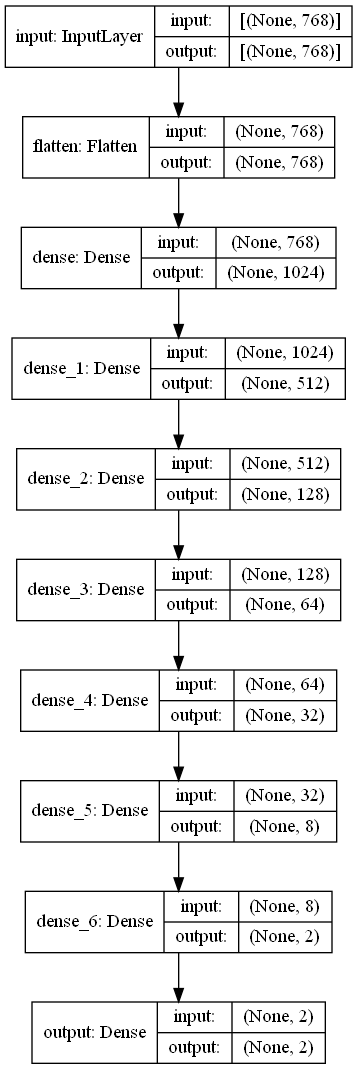

In [139]:
#ref :keras.i/api/util/plot_model
tf.keras.utils.plot_model(Model, to_file='Model_bert.png', show_shapes=True)

#### -tensorboard

In [174]:
%load_ext tensorboard
%tensorboard --logdir bert/fit

<Pre><font size=6>Part-6: Creating a Data pipeline for BERT Model</font> 

1. Download data from <a href="https://drive.google.com/file/d/1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo/view?usp=sharing">here</a>
2. Read the csv file
3. Remove all the html tags
4. Now do tokenization [Part 3 as mentioned above]
    * Create tokens,mask array and segment array
5. Get Embeddings from BERT Model [Part 4 as mentioned above] , let it be X_test
   * Print the shape of output(X_test.shape).You should get (352,768)
6. Predit the output of X_test with the Neural network model which we trained earlier.
7. Print the occurences of class labels in the predicted output

</pre>

In [128]:
#reading the csv file
test_data = pd.read_csv('test.csv')
test_data.head()

,Text
0,Just opened Greenies Joint Care (individually ...
1,This product rocks :) My mom was very happy w/...
2,"The product was fine, but the cost of shipping..."
3,I love this soup. It's great as part of a meal...
4,Getting ready to order again. These are great ...


In [129]:
#remove HTML from the Text column and save in the Text column only
test_data["Text"].apply(cleanhtml)
data = test_data["Text"].values

In [130]:
from itertools import repeat
max_seq_length = 55 #creating a uniform arrays of size 55, padding for less & trimming for more

#creating tokens, masking arrays & the segmentation for the given testset data

tokens_t = [tokenizer.tokenize(val) for val in data]
tokens_te = [sent[0:max_seq_length-2] for sent in tokens_t]

t_tokens =[]; t_mask = [];t_seg = []
for token in tokens_te:
    tokens = ['[CLS]',*token,'[SEP]']
    mask_arr = np.array([1]*len(tokens)+[0]*(max_seq_length-len(tokens)))
    tokens.extend(repeat('[PAD]',max_seq_length-len(tokens)))
    seg_arr = np.array([0]*max_seq_length)
    t_tokens.append(tokenizer.convert_tokens_to_ids(tokens))
    t_mask.append(mask_arr)
    t_seg.append(seg_arr)
#arrays for the tokens,mask,segments    
data_tokens = np.array(t_tokens)
data_mask = np.array(t_mask)
data_segment = np.array(t_seg)   

In [162]:
# get the output, BERT model will give one output so save in
# data_pooled_output
X_test=bert_model.predict([data_tokens,data_mask,data_segment])
print("Print the shape of output:", X_test.shape)

Print the shape of output: (352, 768)


In [132]:
import os
os.listdir(filepath)

from tensorflow.keras.models import load_model
model = load_model(filepath)

['assets', 'keras_metadata.pb', 'saved_model.pb', 'variables']

In [171]:
#here we'll predict using our best model saved
predictions = model.predict_classes(X_test)
print("predictions made--> ",predictions.shape[0])
print("\npredictions array sample")
predictions[:50]

predictions made-->  352

predictions array sample


array([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1], dtype=int64)

In [173]:
# summarize the first 10 cases          #ref: machinelearningmastery
for i in range(10):
    print('%s \n========>> %d\n' % (data[i], predictions[i]))

Just opened Greenies Joint Care (individually sealed) in December 2011 and found small worm crawling all over it.  Next one looked fine, but really supposed to trust these now? 
========>> 0

This product rocks :) My mom was very happy w/the product it was excatly as described we loved seeing all the candy and eating it all :) 
========>> 1

The product was fine, but the cost of shipping was more than the cost<br />of the tea.  Won't make that mistake again. 
========>> 1

I love this soup. It's great as part of a meal or as a nutritious and satisifying low-in-calorie snack. For a light lunch, I stir in some shreeded cheese. 
========>> 1

Getting ready to order again. These are great because they compost very quickly. BUT, some of the bags have tears in the bottom, so remember to always carry extra so you have emergency 'back-up' bags!  A bit costly but, again, better for the environment. 
========>> 1

These were delicious, but not wrapped as well as I think they should be.  They kin

# Summary

- BERT stands for Bidirectional Encoder Representations from Transformers. It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context.

- Here we're using the bert model to provide us pretrained embedding Vector for a given review, using transfer learning helps us reduce the training time & resources required.Building our model on top of a pretrained model gives us a remarkable performance

- Thereafter we're using  the embedding data applying a NeuralNet to train for binary classification.

- Also we're creating a pipeline for reviews classification where predictions are made using our best model.
- From the data displayed & the predictions made, we can get an idea how our model is making a good level of predictions for the reviews provided

Ref: AAIC Course & the reference notebook, Analytics Vidya,machine learning mastery